# TELCO CHURN CLASSIFICATION PROJECT

### Overview:

### Goals:
    1. Identify primary drivers of churn
    2. Demonstrate impact of driver on churn
    3. Present recommendations to address churn driver
    
## 1. Planning
    a. Acquire, prep and explore data
    b. Build hypothesis
    c. Isolate range in monthly charges where spikes of churn are occuring.
    d. Identify feature most often found in those spikes of churn.
    e. Determine if feature and churn are significantly associated (Chi Square)
    f. Rule out feature being significantly associated with other features (Chi Square)
    
    ** INSERT MODEL AND EVAL DETAILS HERE
    
    g. Extract takeaways:
        - Extent of churn due to isolated feature
        - Churn further irritated by what other features
        - ** MODEL AND EVAL TAKEAWAYS
    h. Develop recommendations


In [1]:
# standard ds imports
import numpy as np
import pandas as pd

# for wrangling and exploration
import acquire
import prepare
import explore

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical analysis
import scipy.stats as stats

# for model evaluation
import sklearn.metrics as met

## 2. Data Aquisition and Preparation

In [2]:
telco = acquire.get_telco_data()
telco = prepare.prep_telco(telco)
train, val, test = prepare.split_data(telco, 'churn_Yes')
train.shape, val.shape, test.shape

((4225, 27), (1409, 27), (1409, 27))

In [3]:
train['extras'] = train['online_security'] + train['online_backup']+train['device_protection']+train['tech_support']+ train['streaming_tv']+train['streaming_movies']
train = train.drop(columns=['online_security', 'online_backup', 'device_protection','tech_support','streaming_tv','streaming_movies'])

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 5911 to 3586
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                4225 non-null   object 
 1   senior_citizen             4225 non-null   int64  
 2   tenure                     4225 non-null   int64  
 3   multiple_lines             4225 non-null   int64  
 4   monthly_charges            4225 non-null   float64
 5   total_charges              4225 non-null   float64
 6   gender_Male                4225 non-null   uint8  
 7   partner_Yes                4225 non-null   uint8  
 8   dependents_Yes             4225 non-null   uint8  
 9   phone_service_Yes          4225 non-null   uint8  
 10  paperless_billing_Yes      4225 non-null   uint8  
 11  churn_Yes                  4225 non-null   uint8  
 12  Month-to-month             4225 non-null   uint8  
 13  One year                   4225 non-null   ui

## 3. Data Exploration

#### Hypothesis 1:

    Ho -> There is a less than or equal probability of churn if a customer has fiber optic than not
    Ha -> There is a greater probability of churn if a customer has fiber optic than not

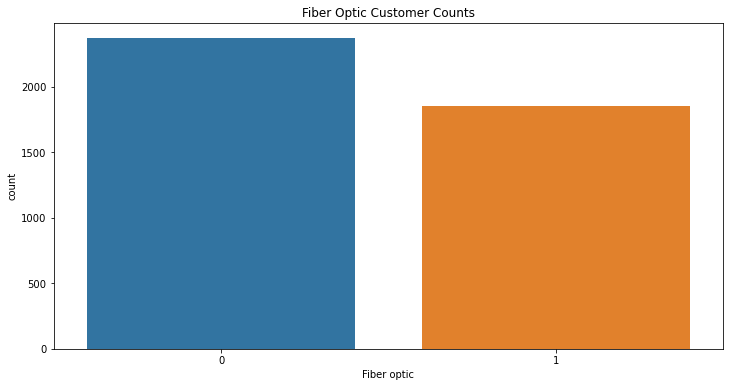

2370 customers or 56.1% do not have fiber optic.
1855 customers or 43.9% have fiber optic.

---------------------------------------------------------------------------------------------------------------



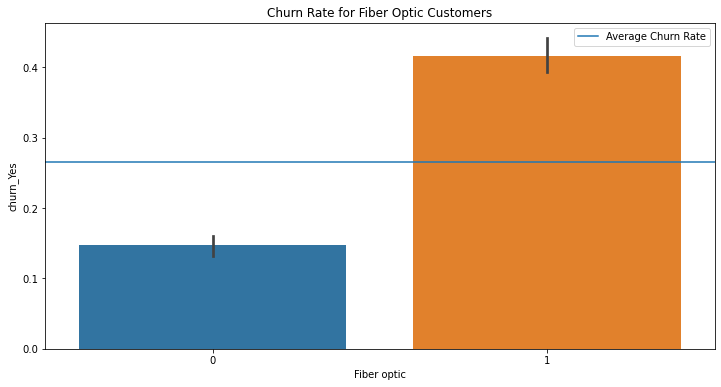

14.7% of all customers without fiber optic churn.
41.7% of all customers with fiber optic churn.


In [49]:
# plot the count of customers in the train dataset against the fiber optic feature
plt.figure(figsize=(12,6))
sns.countplot(x='Fiber optic', data=train)
plt.title('Fiber Optic Customer Counts')
plt.show()

# calculate the count of customers with and without fiber optic
no_fo = train[['Fiber optic']].value_counts()[0]
yes_fo = train[['Fiber optic']].value_counts()[1]

# calculate the percentage of customers with and without fiber optic
no_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[0], 1)
yes_fo_per = round((train[['Fiber optic']].value_counts(normalize=True)*100)[1], 1)

# print the previously calculated values in statements
print(f'{no_fo} customers or {no_fo_per}% do not have fiber optic.')
print(f'{yes_fo} customers or {yes_fo_per}% have fiber optic.')

# make some space between graphs
print('')
print('---------------------------------------------------------------------------------------------------------------')
print('')

# plot the feature fiber optic against the target of churn
plt.figure(figsize=(12,6))
sns.barplot(data=train, x='Fiber optic', y='churn_Yes')
# add a line for average rate of churn in the train data set (regardless of features)
rate = train.churn_Yes.mean()
plt.axhline(rate, label= 'Average Churn Rate')
plt.legend()
plt.title('Churn Rate for Fiber Optic Customers')
plt.show()

# calculate the churn rate for customers with and without fiber optic
yes_churn_fo_per = round(((train[(train['Fiber optic']==1)&(train.churn_Yes)==1].shape[0]) / (train[train['Fiber optic'] == 1].shape[0]))*100, 1)
no_churn_fo_per = round(((train[(train['Fiber optic']==0)&(train.churn_Yes)==1].shape[0]) / (train[train['Fiber optic'] == 0].shape[0]))*100, 1)

# print the previous calulations in statements
print(f'{no_churn_fo_per}% of all customers without fiber optic churn.')
print(f'{yes_churn_fo_per}% of all customers with fiber optic churn.')

#### T-test: Fiber Optic vs Churn

In [52]:
# set up variables. Customers with fiber optic vs customers without. 
fiber = train[train['Fiber optic']==1].churn_Yes
no_fiber = train[train['Fiber optic']==0].churn_Yes

# set alpha to 0.05 (due to 95% confidence level)
α = 0.05

In [53]:
# test for equal variance
s, p = stats.levene(fiber, no_fiber)

if p < α:
    print('Variances are not similar. Must set equal_var to True during t-test.')
else:
    print('Variances are similar. Continues to t-test without any additional steps.')

Variances are not similar. Must set equal_var to True during t-test.


In [54]:
# run t-test
t, p = stats.ttest_ind(fiber, no_fiber, equal_var=False)
if t > 0 and p/2 < α:
    print('''Reject the null hypothesis.
    Findings suggest there is a greater probability of churn if a customer has fiber optic than not.''')
else:
    print('''Fail to reject the null hypothesis.
    Findings suggest there is a less than or equal probability of churn if a customer has fiber optic than not.''')

Reject the null hypothesis.
    Findings suggest there is a greater probability of churn if a customer has fiber optic than not.


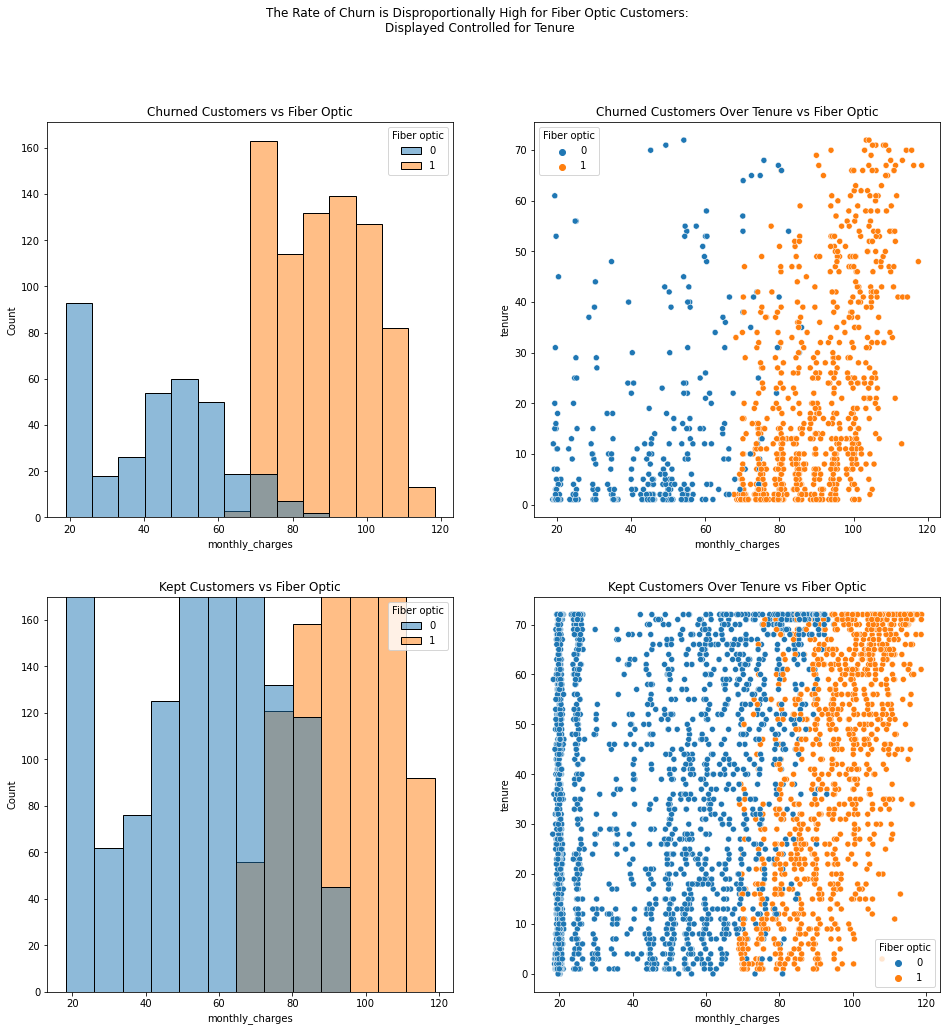

In [51]:
fig, axes = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('''The Rate of Churn is Disproportionally High for Fiber Optic Customers: 
Displayed Controlled for Tenure''')

# Churning customers, no matter where in tenure, are churning the most when they have fiber optic. 
axes[0,0].set_title('Churned Customers vs Fiber Optic')
axes[0,1].set_title('Churned Customers Over Tenure vs Fiber Optic')
axes[1,0].set_title('Kept Customers vs Fiber Optic')
axes[1,1].set_title('Kept Customers Over Tenure vs Fiber Optic')

sns.histplot(ax=axes[0,0], data=train[train.churn_Yes == 1], x='monthly_charges', hue='Fiber optic')
sns.scatterplot(ax=axes[0,1], data=train[(train.churn_Yes == 1)], y='tenure', x='monthly_charges', hue='Fiber optic')
sns.histplot(ax=axes[1,0], data=train[train.churn_Yes == 0], x='monthly_charges', hue='Fiber optic')
axes[1,0].set_ylim(0,170)
sns.scatterplot(ax=axes[1,1], data=train[(train.churn_Yes == 0)], y='tenure', x='monthly_charges', hue='Fiber optic')
plt.show()
# would look further into when customers (get fiber optic vs their churn date) vs (non-fiber optic vs churn date)

## 4. Data Modeling

## 5. Model Evaluation

# CONCLUSTION

### Goals and how reached:

### Key Findings:

### Recommendations:

### Next Steps: